## LSTM using Differences of Close values
### 9 from report

Anastasios Koutsogiannopoulos, 03321

Fani Banou, 03322

Ioannis Sakellariou, 03144

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from google.colab import drive

### Data Loading and Preprocessing

In [ ]:
def mount_drive():
    """
    Mount Google Drive.
    """
    drive.mount('/content/drive')

In [ ]:
def load_data(file_path):
    """
    Loads the CSV file, converts UNIX timestamps to datetime,
    sets the datetime as the index, and sorts the data in ascending order.
    """
    data = pd.read_csv(file_path)
    data['date'] = pd.to_datetime(data['unix'], unit='s')
    data.set_index('date', inplace=True)
    data = data.sort_index(ascending=True)
    return data


In [ ]:
def resample_data(data, sampling_type):
    """
    Resamples the data based on the sampling_type.

    Args:
        sampling_type (int):
            0 -> minute sampling,
            1 -> hourly sampling,
            2 -> daily sampling,
            3 -> monthly sampling.

    Returns:
        DataFrame with only the 'close' column.
    """
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    if sampling_type == 0:
        print("> Minute Sampling!")
        data_resampled = numeric_data
    elif sampling_type == 1:
        print("> Hourly Sampling!")
        data_resampled = numeric_data.resample('1h').mean()
    elif sampling_type == 2:
        print("> Daily Sampling!")
        data_resampled = numeric_data.resample('1d').mean()
    elif sampling_type == 3:
        print("> Monthly Sampling!")
        data_resampled = numeric_data.resample('1m').mean()
    else:
        raise ValueError("Invalid sampling type. Choose 0, 1, 2, or 3.")
    data_resampled = data_resampled[['close']].dropna()
    return data_resampled

In [ ]:
def split_data(data, train_end_date, test_start_date, test_end_date):
    """
    Splits the data into training and testing sets using given date ranges.
    """
    train_data = data[:train_end_date]
    test_data = data[test_start_date:test_end_date]
    return train_data, test_data


In [ ]:
def scale_dataset(train_data):
    """
    Scales the training and test sets using MinMaxScaler.
    Returns scaled DataFrames with original indices and columns and the scaler.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    train_scaled = pd.DataFrame(train_scaled, index=train_data.index, columns=train_data.columns)
    return train_scaled, scaler

In [ ]:
def create_dataset(data, time_step, forecast_horizon):
    """
    Creates sliding windows sequences and corresponding multi-step targets.

    For each window of length time_step, the target is the next forecast_horizon values.
    """
    X, y = [], []
    for i in range(len(data) - time_step - forecast_horizon + 1):
        X.append(data.iloc[i:i+time_step].values)
        y.append(data.iloc[i+time_step:i+time_step+forecast_horizon, 0].values)
    return np.array(X), np.array(y)

### Model Training


In [ ]:

def train_model_custom(X_train, y_train, epochs=100, patience=15, learning_rate=0.001):
    """
    Builds and trains a LSTM model for multi-step forecasting.
    Performs an internal train-validation split.
    """
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(32, activation='relu'),
        Dense(y_train.shape[1])  # Number of forecast steps
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs,
                        batch_size=128, verbose=1, callbacks=[early_stopping], shuffle=False)
    print("Model training complete!")
    return model, history

### Forecasting and Reconstruction

In [ ]:

def forecast_model(model, last_window):
    """
    Uses the trained model to forecast based on the last input window.
    """
    input_seq = last_window.reshape(1, last_window.shape[0], last_window.shape[1])
    predictions = model.predict(input_seq, verbose=1)
    return predictions[0]


In [ ]:

def reconstruct_forecast(predictions, last_close_value):
    """
    Reconstructs the original close forecast from the predicted differences.
    """
    forecast_original = [last_close_value + predictions[0]]
    for i in range(1, len(predictions)):
        forecast_original.append(forecast_original[i-1] + predictions[i])
    return np.array(forecast_original).reshape(-1, 1)

###  Evaluation and Plotting

In [ ]:
def compute_metrics(y_true, y_pred):
    """
    Computes evaluation metrics: MAE, MSE, RMSE
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse


In [ ]:
def plot_forecast_results(y_true, y_pred, title="Forecast vs True Prices"):
    """
    Plots the true and predicted prices.
    """
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label="True Prices", color="blue")
    plt.plot(y_pred, label="Predicted Prices", color="orange")
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Bitcoin Price")
    plt.legend()
    plt.show()

In [ ]:
def plot_loss_history(history, title="Loss vs Validation Loss"):
    """
    Plots the training and validation loss curves.
    """
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label="Training Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

### Predict & Evaluate

In [ ]:
def predict_and_evaluate_model(model, X_train, y_test, scaler, history, last_close_value):
    """
    Uses the last training window to forecast the differences, reconstructs the
    forecast of close values, inverse-transforms predictions and true values,
    computes and prints evaluation metrics, and plots the forecast and loss curves.
    """
    # Forecast differences using the last training window
    forecast_differences_scaled = forecast_model(model, X_train[-1])

    forecast_differences = scaler.inverse_transform(forecast_differences_scaled.reshape(-1,1))

    # Reconstruct forecast using the last training close value
    forecast_close = reconstruct_forecast(forecast_differences, last_close_value)

    mae, mse, rmse = compute_metrics(y_test, forecast_close)
    print("Single Experiment Results:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

    plot_forecast_results(y_test, forecast_close, title="Forecast vs True Prices (Single Experiment)")
    plot_loss_history(history, title="Loss vs Validation Loss (Single Experiment)")

    return mae, rmse, forecast_close, y_test

### Multiple Experiments

In [ ]:
def run_multiple_experiments1(num_runs, X_train, y_train, y_test, scaler, last_close_value):
    """
    Run the training and evaluation multiple times num_runs and compute average metrics,
    average forecast, and average loss curves.
    """
    mae_list = []
    rmse_list = []
    predictions_list = []
    histories_list = []
    train_times = []         # To store execution times for model training
    predict_times = []      # To store execution times for predict

    for run in range(num_runs):
        print(f"\nRun {run+1}/{num_runs}")
        # Train the model
        start_time = time.time()
        model, history = train_model_custom(X_train, y_train)
        train_time = time.time() - start_time
        train_times.append(train_time)

        # Evaluate the model
        start_time = time.time()
        mae, rmse, forecast_close, y_test_eval = predict_and_evaluate_model(model, X_train, y_test, scaler, history, last_close_value)
        predict_time = time.time() - start_time
        predict_times.append(predict_time)

        mae_list.append(mae)
        rmse_list.append(rmse)
        predictions_list.append(forecast_close)
        histories_list.append(history)

    # Compute average metrics
    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    print("\nAverage Evaluation Metrics over {} Runs:".format(num_runs))
    print(f"Average MAE: {avg_mae:.4f}")
    print(f"Average RMSE: {avg_rmse:.4f}")
    # Compute and print average execution times
    avg_train_time = np.mean(train_times)
    avg_predict_time = np.mean(predict_times)
    print(f"\nAverage Execution Times over {num_runs} Runs:")
    print(f"Model Training Time: {avg_train_time:.4f} seconds")
    print(f"Predicting Time: {avg_predict_time:.4f} seconds")

    # Compute average forecast averaging predictions across runs
    avg_forecast = np.mean(np.array(predictions_list), axis=0)
    plot_forecast_results(y_test_eval, avg_forecast, title="Average Forecast vs True Prices (Multiple Runs)")

    # Compute average loss curves
    min_epochs = min(len(h.history['loss']) for h in histories_list)
    avg_loss = np.mean([h.history['loss'][:min_epochs] for h in histories_list], axis=0)
    avg_val_loss = np.mean([h.history['val_loss'][:min_epochs] for h in histories_list], axis=0)

    plt.figure(figsize=(10,5))
    epochs_range = range(1, min_epochs+1)
    plt.plot(epochs_range, avg_loss, label="Average Training Loss")
    plt.plot(epochs_range, avg_val_loss, label="Average Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Average Loss Curves over {num_runs} Runs")
    plt.legend()
    plt.show()


### Main Function

Mounted at /content/drive
> Hourly Sampling!
Shape of X_train: (9672, 24, 1)
Shape of y_train: (9672, 240)

Running Multiple Experiments (10 runs)...

Run 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.1797 - mae: 0.3586 - val_loss: 0.0018 - val_mae: 0.0314
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0025 - mae: 0.0355 - val_loss: 0.0012 - val_mae: 0.0229
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0226
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - lo

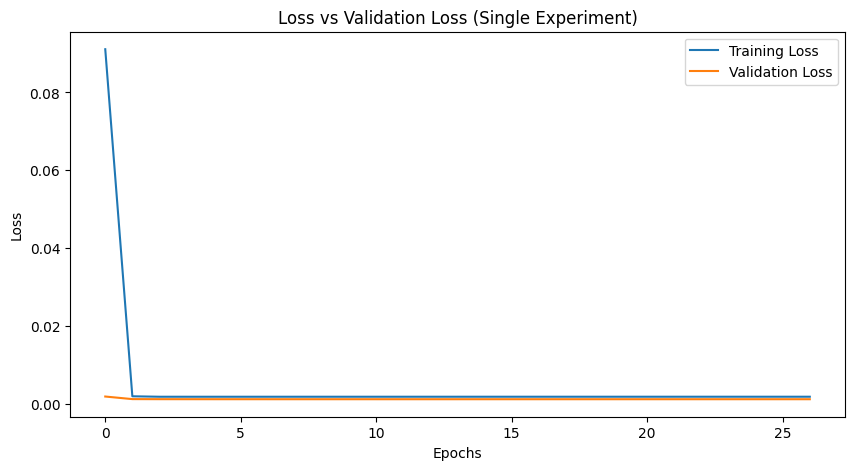


Run 2/10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1905 - mae: 0.3763 - val_loss: 0.0035 - val_mae: 0.0383
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0032 - mae: 0.0383 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 -

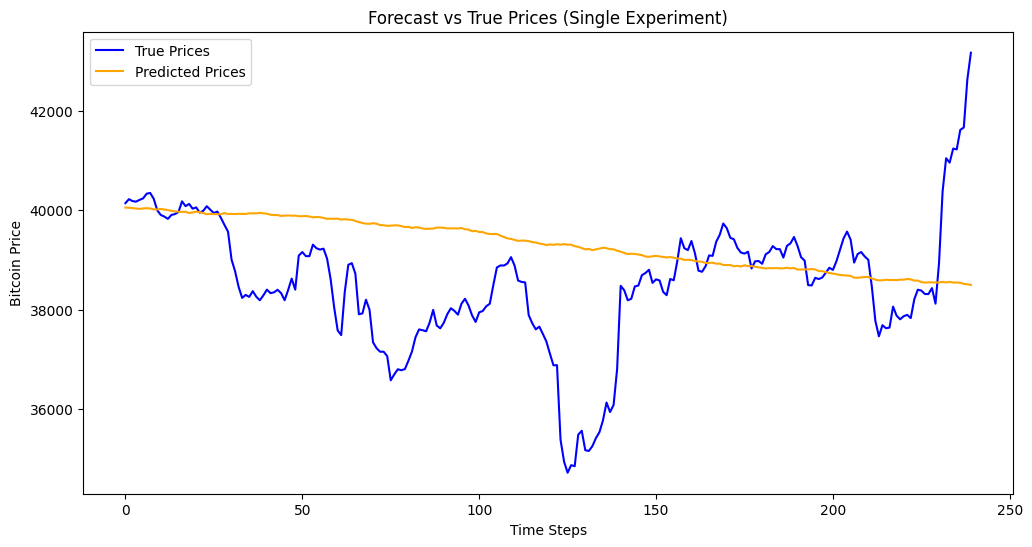

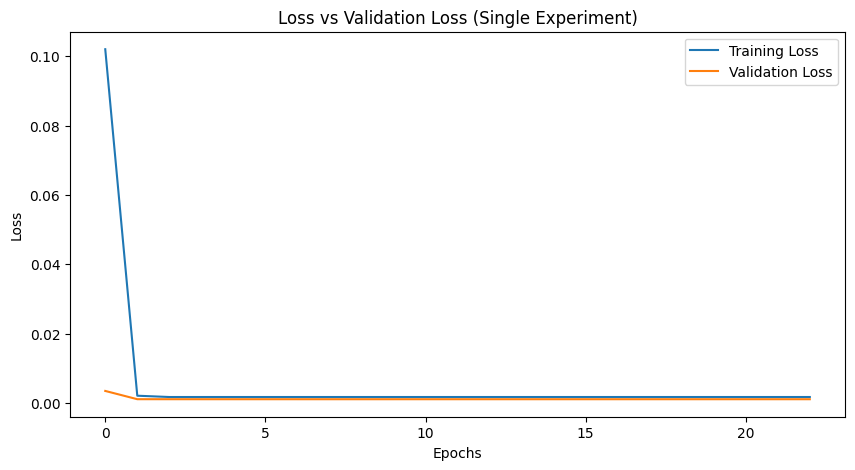


Run 3/10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1845 - mae: 0.3673 - val_loss: 0.0025 - val_mae: 0.0343
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0027 - mae: 0.0366 - val_loss: 0.0012 - val_mae: 0.0226
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 -

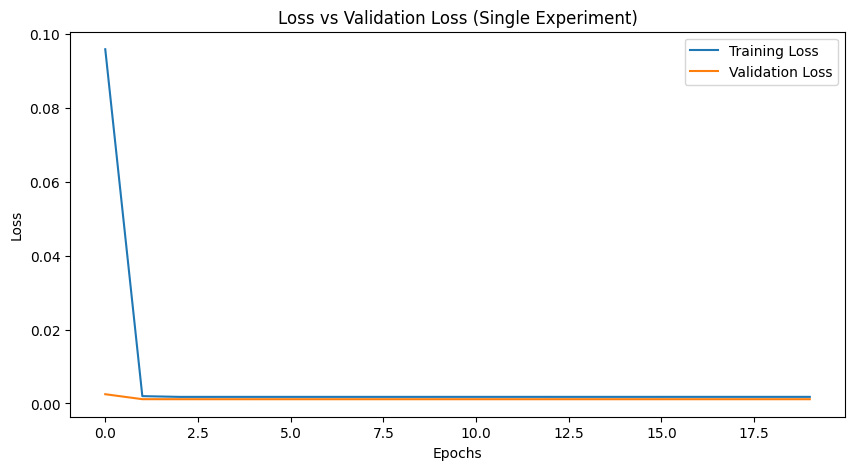


Run 4/10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1800 - mae: 0.3608 - val_loss: 0.0020 - val_mae: 0.0319
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0026 - mae: 0.0357 - val_loss: 0.0012 - val_mae: 0.0226
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 -


Run 5/10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1792 - mae: 0.3609 - val_loss: 0.0019 - val_mae: 0.0323
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025 - mae: 0.0357 - val_loss: 0.0012 - val_mae: 0.0226
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0011 - val_mae: 0.0224
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0011 - val_mae: 0.0224
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0011 - val_mae: 0.0224
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0011 - val_mae: 0.0224
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Single Experiment Results:
MAE: 1169.8429
MSE: 2505439.1953
RMSE: 1582.8579


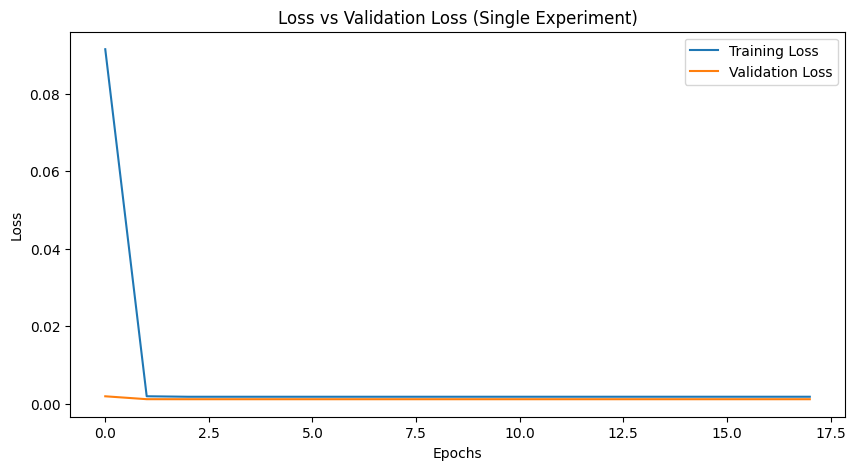


Run 6/10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2004 - mae: 0.3898 - val_loss: 0.0043 - val_mae: 0.0401
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0035 - mae: 0.0392 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
Single Experiment Results:
MAE: 1288.4414
MSE: 2856686.3239
RMSE: 1690.1735


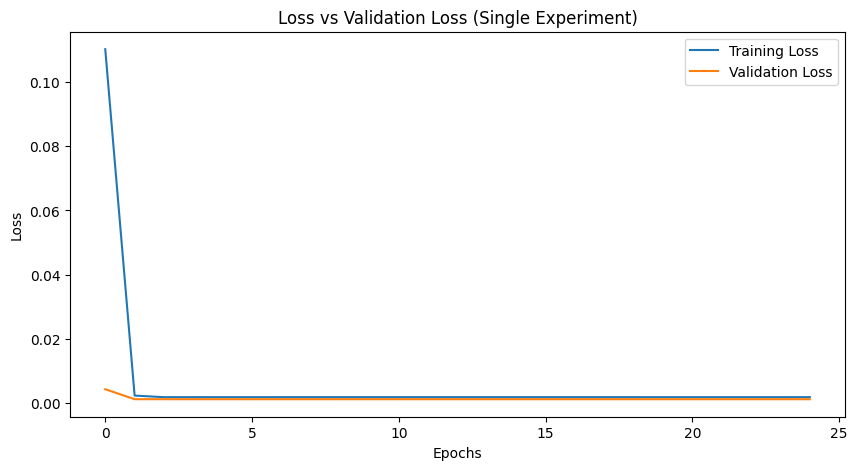


Run 7/10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1841 - mae: 0.3667 - val_loss: 0.0025 - val_mae: 0.0359
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0027 - mae: 0.0368 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 -


Run 8/10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1900 - mae: 0.3755 - val_loss: 0.0023 - val_mae: 0.0353
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0027 - mae: 0.0368 - val_loss: 0.0012 - val_mae: 0.0229
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022 -


Run 9/10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1895 - mae: 0.3737 - val_loss: 0.0023 - val_mae: 0.0340
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0027 - mae: 0.0367 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 -

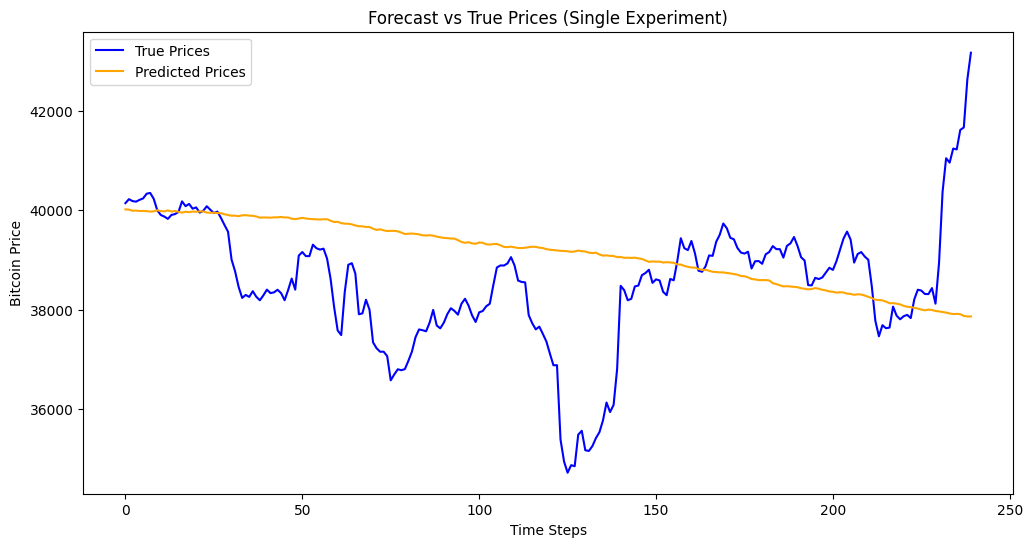


Run 10/10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2029 - mae: 0.3968 - val_loss: 0.0028 - val_mae: 0.0379
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - mae: 0.0375 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 -

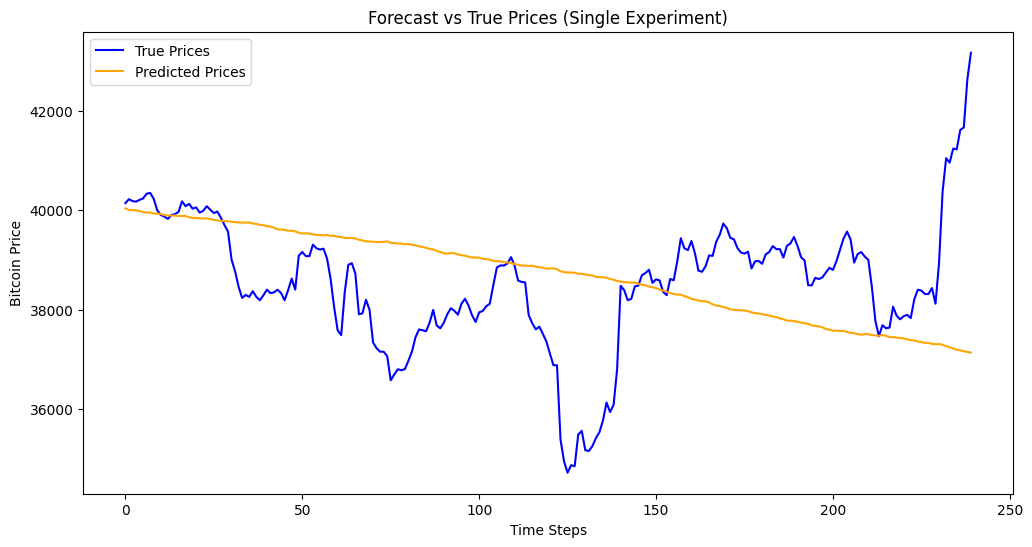

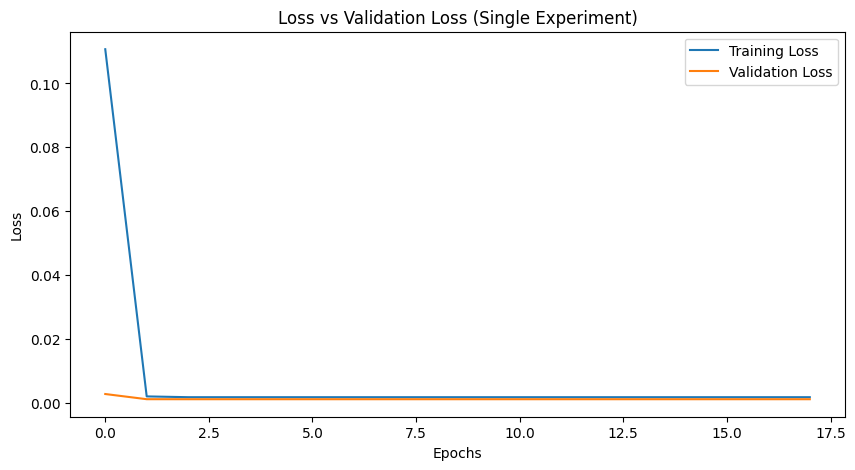


Average Evaluation Metrics over 10 Runs:
Average MAE: 1224.1342
Average RMSE: 1665.2377

Average Execution Times over 10 Runs:
Model Training Time: 27.2874 seconds
Predicting Time: 0.8997 seconds


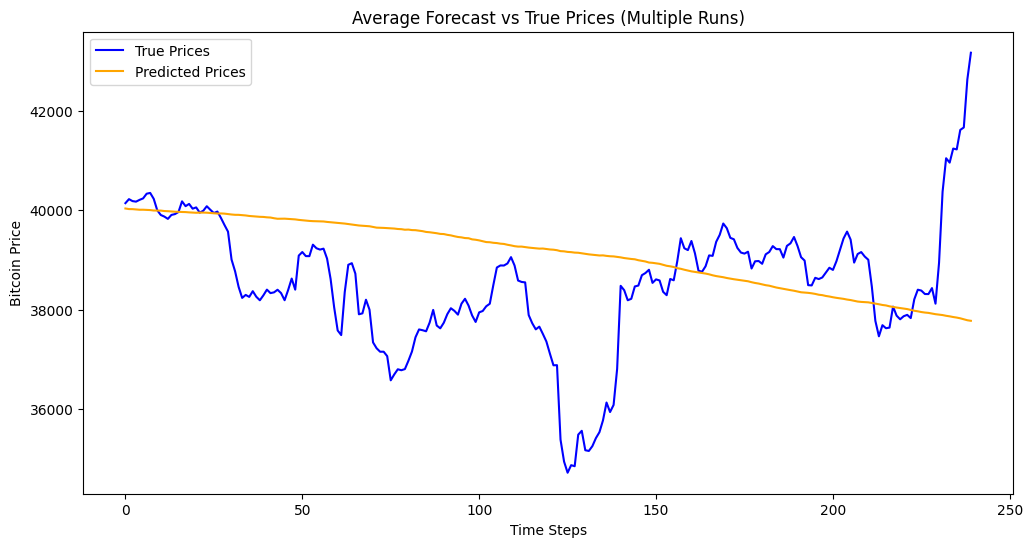

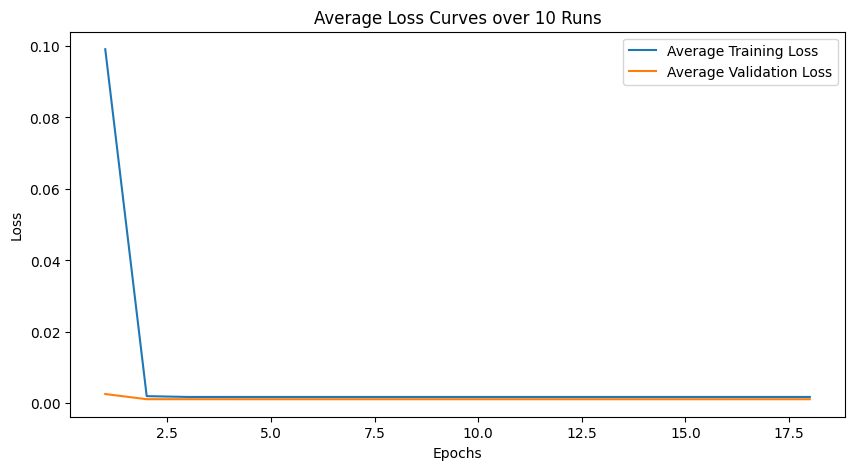

In [ ]:
def main():
    # Mount drive
    mount_drive()

    # Define file path and parameters
    file_path = '/content/drive/MyDrive/bitcoin-dataset.csv'
    sampling_time = 1  # 0: minute, 1: hourly, 2: daily, 3: monthly
    window_size = 24

    # Load data and resample
    data = load_data(file_path)
    data_resampled = resample_data(data, sampling_time)

    # Define split dates
    train_end_date = '2022-02-18 23:59:59'
    test_start_date = '2022-02-19 00:00:00'
    test_end_date = '2022-02-28 23:59:59'
    train_data, test_data = split_data(data_resampled, train_end_date, test_start_date, test_end_date)

    # Get last training close value scaled to reconstruct forecast
    last_close_value = train_data['close'].iloc[-1]

    # For this code, we use differences of the 'close' values from the training set
    train_diff = train_data['close'].diff().dropna()
    train_diff = pd.DataFrame(train_diff, index=train_diff.index, columns=['close'])

    # Scale the datasets
    train_scaled, scaler = scale_dataset(train_diff)

    # Create training dataset windows
    X_train, y_train = create_dataset(train_scaled, window_size, len(test_data))
    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of y_train: {y_train.shape}")

    # Test targets from the test set remain as is
    y_test = test_data.iloc[:, 0].values

    # ---- Single Experiment ----
    # num_features = X_train.shape[2]
    # model, history = train_model_custom(X_train, y_train)
    # predict_and_evaluate_model(model, X_train, y_test, scaler, history, last_close_value)

    # ---- Multiple Experiments ----
    print("\nRunning Multiple Experiments (10 runs)...")
    run_multiple_experiments1(10, X_train, y_train, y_test, scaler, last_close_value)


if __name__ == "__main__":
    main()

